In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [70]:
import numpy as np
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import logistic, multivariate_normal, norm
from scipy.special import expit

from keras.models import Model, Sequential
from keras.layers import Activation, Add, Dense, Dot, Input
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from IPython.display import HTML, SVG, display_html
from tqdm import tnrange, tqdm_notebook

In [3]:
# display animation inline
plt.rc('animation', html='html5')
plt.style.use('seaborn-notebook')
sns.set_context('notebook')

In [4]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [5]:
K.tf.__version__

'1.2.1'

In [6]:
LATENT_DIM = 2
NOISE_DIM = 3
BATCH_SIZE = 200
PRIOR_VARIANCE = 2.
LEARNING_RATE = 3e-3
PRETRAIN_EPOCHS = 60

### Bayesian Logistic Regression (Synthetic Data)

In [7]:
z_min, z_max = -5, 5

In [8]:
z1, z2 = np.mgrid[z_min:z_max:300j, z_min:z_max:300j]

In [9]:
z_grid = np.dstack((z1, z2))
z_grid.shape

(300, 300, 2)

In [10]:
prior = multivariate_normal(mean=np.zeros(LATENT_DIM), 
                            cov=PRIOR_VARIANCE)

In [11]:
log_prior = prior.logpdf(z_grid)
log_prior.shape

(300, 300)

In [13]:
np.allclose(log_prior, 
            -.5*np.sum(z_grid**2, axis=2)/PRIOR_VARIANCE \
            -np.log(2*np.pi*PRIOR_VARIANCE))

True

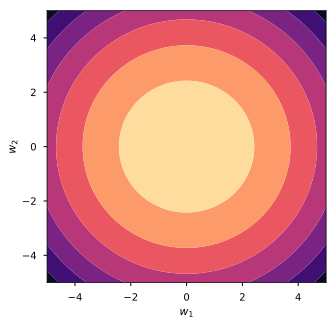

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(z1, z2, log_prior, cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(z_min, z_max)
ax.set_ylim(z_min, z_max)

plt.show()

In [16]:
x = np.array([0, 5, 8, 12, 50])

In [37]:
def log_likelihood(z, x, beta_0=3., beta_1=1.):
    beta = beta_0 + np.sum(beta_1*np.maximum(0, z**3), axis=-1)
    return -np.log(beta) - x/beta

In [44]:
llhs = log_likelihood(z_grid, x.reshape(-1, 1, 1))
llhs.shape

(5, 300, 300)

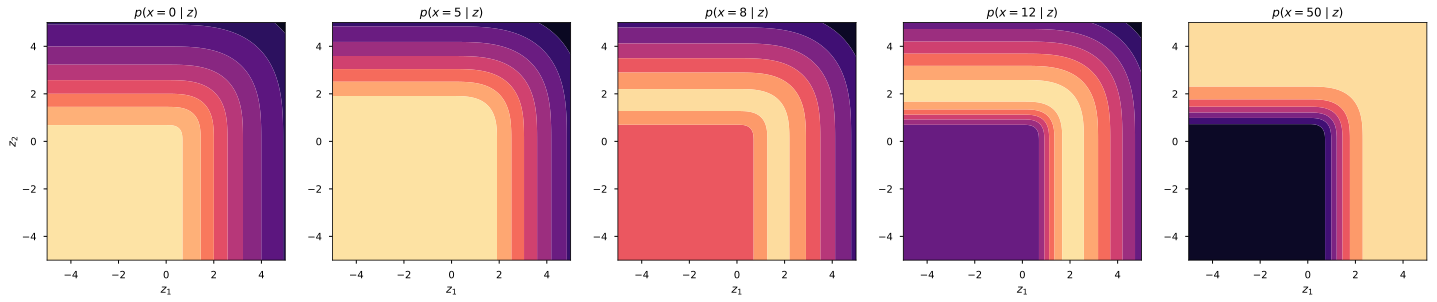

In [59]:
fig, axes = plt.subplots(ncols=len(x), nrows=1, figsize=(20, 4))
fig.tight_layout()

for i, ax in enumerate(axes):
    
    ax.contourf(z1, z2, llhs[i,::,::], cmap=plt.cm.magma)

    ax.set_xlim(z_min, z_max)
    ax.set_ylim(z_min, z_max)
    
    ax.set_title('$p(x = {{{0}}} \mid z)$'.format(x[i]))
    ax.set_xlabel('$z_1$')    
    
    if not i:
        ax.set_ylabel('$z_2$')

plt.show()

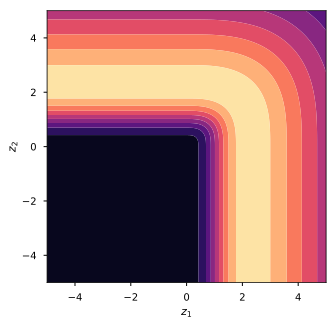

In [60]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(z1, z2, np.sum(llhs, axis=0), 
                cmap=plt.cm.magma)

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

ax.set_xlim(z_min, z_max)
ax.set_ylim(z_min, z_max)

plt.show()

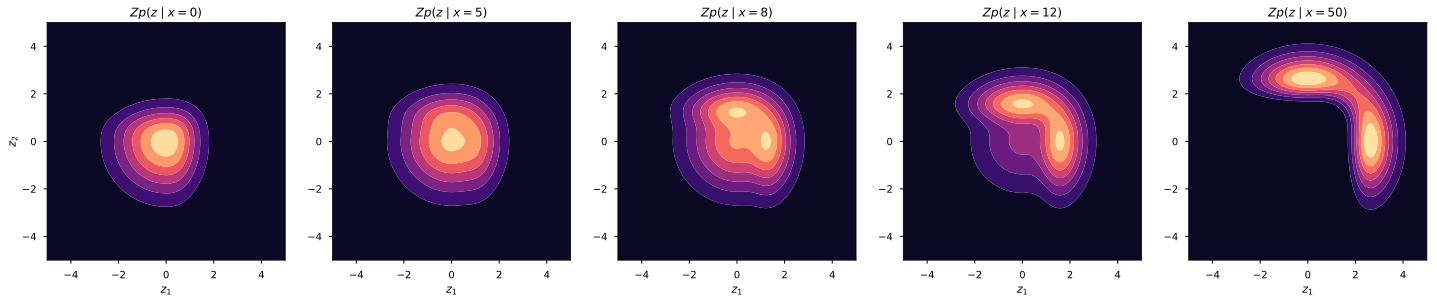

In [61]:
fig, axes = plt.subplots(ncols=len(x), nrows=1, figsize=(20, 4))
fig.tight_layout()

for i, ax in enumerate(axes):
    
    ax.contourf(z1, z2,  np.exp(log_prior+llhs[i,::,::]), 
                cmap='magma')

    ax.set_xlim(z_min, z_max)
    ax.set_ylim(z_min, z_max)
    
    ax.set_title('$Zp(z \mid x = {{{0}}})$'.format(x[i]))
    ax.set_xlabel('$z_1$')    
    
    if not i:
        ax.set_ylabel('$z_2$')

plt.show()

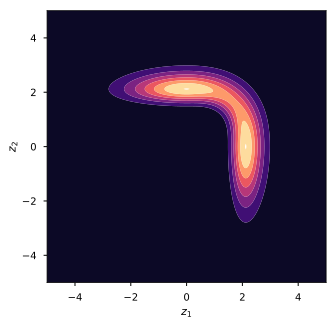

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(z1, z2, 
            np.exp(log_prior+np.sum(llhs, axis=0)), 
            cmap='magma')

ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

ax.set_xlim(z_min, z_max)
ax.set_ylim(z_min, z_max)

plt.show()

## Model Definitions

### Density Ratio Estimator (Discriminator) Model

$T_{\psi}(x, z)$

In [84]:
x_input = Input(shape=(1,), name='x')
x_hidden = Dense(10, activation='relu')(x_input)
x_hidden = Dense(20, activation='relu')(x_hidden)

In [85]:
z_input = Input(shape=(LATENT_DIM,), name='z')
z_hidden = Dense(10, activation='relu')(z_input)
z_hidden = Dense(20, activation='relu')(z_hidden)

In [86]:
discrim_hidden = Add()([x_hidden, z_hidden])
discrim_hidden = Dense(10, activation='relu')(discrim_hidden)
discrim_hidden = Dense(20, activation='relu')(discrim_hidden)
discrim_logit = Dense(1, activation=None, 
                       name='logit')(discrim_hidden)
discrim_out = Activation('sigmoid')(discrim_logit)

In [87]:
discriminator = Model(inputs=[x_input, z_input], outputs=discrim_out)
discriminator.compile(optimizer=Adam(lr=LEARNING_RATE),
                      loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

In [88]:
ratio_estimator = Model(
    inputs=discriminator.inputs, 
    outputs=discrim_logit)

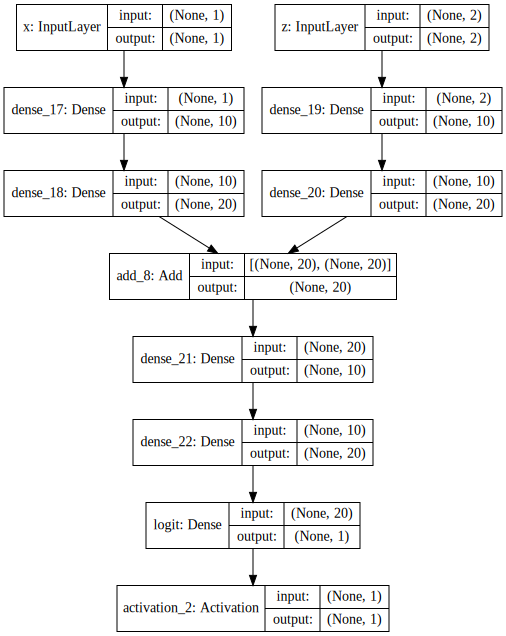

In [89]:
SVG(model_to_dot(discriminator, show_shapes=True)
    .create(prog='dot', format='svg'))

In [105]:
np.ones((32, 5)) + np.ones((16, 5))

ValueError: operands could not be broadcast together with shapes (32,5) (16,5) 

In [112]:
z_grid_ratio = ratio_estimator.predict([np.ones((16, 1)), np.ones((32, 2))])
z_grid_ratio.shape

(16, 1)

Initial density ratio, prior to any training

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [ ]:
discriminator.evaluate(prior.rvs(size=5), np.zeros(5))

### Approximate Inference Model

$z_{\phi}(x, \epsilon)$

Here we only consider

$z_{\phi}(\epsilon)$

$z_{\phi}: \mathbb{R}^3 \to \mathbb{R}^2$

In [ ]:
inference = Sequential()
inference.add(Dense(10, input_dim=NOISE_DIM, activation='relu'))
inference.add(Dense(20, activation='relu'))
inference.add(Dense(LATENT_DIM, activation=None))
inference.summary()

The variational parameters $\phi$ are the trainable weights of the approximate inference model

In [ ]:
phi = inference.trainable_weights
phi

In [ ]:
SVG(model_to_dot(inference, show_shapes=True)
    .create(prog='dot', format='svg'))

In [ ]:
w_sample_prior = prior.rvs(size=BATCH_SIZE)
w_sample_prior.shape

In [ ]:
eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
w_sample_posterior = inference.predict(eps)
w_sample_posterior.shape

In [ ]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap=plt.cm.magma)

ax.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [ ]:
metrics = discriminator.evaluate(inputs, targets)

In [ ]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

In [ ]:
metrics

In [ ]:
metrics_dict = dict(zip(discriminator.metrics_names, metrics))

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

metrics_plots = {k:ax1.plot([], label=k)[0] 
                 for k in ['loss']} # discriminator.metrics_names}

ax1.set_xlabel('epoch')
ax1.legend(loc='upper left')

ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

#### Discriminator pre-training

In [ ]:
def train_animate(epoch_num, prog_bar, batch_size=200, steps_per_epoch=15):

    # Single training epoch
    
    for step in tnrange(steps_per_epoch, unit='step', leave=False):

        w_sample_prior = prior.rvs(size=batch_size)

        eps = np.random.randn(batch_size, NOISE_DIM)
        w_sample_posterior = inference.predict(eps)

        inputs = np.vstack((w_sample_prior, w_sample_posterior))
        targets = np.hstack((np.zeros(batch_size), np.ones(batch_size)))

        metrics = discriminator.train_on_batch(inputs, targets)

    # Plot Metrics
        
    metrics_dict = dict(zip(discriminator.metrics_names, metrics))

    for metric in metrics_plots:
        metrics_plots[metric].set_xdata(np.append(metrics_plots[metric].get_xdata(), 
                                                  epoch_num))    
        metrics_plots[metric].set_ydata(np.append(metrics_plots[metric].get_ydata(), 
                                                  metrics_dict[metric]))
        metrics_plots[metric].set_label('{} ({:.2f})' \
                                        .format(metric, 
                                                metrics_dict[metric]))
    
    ax1.set_xlabel('epoch {:2d}'.format(epoch_num))
    ax1.legend(loc='upper left')

    ax1.relim()
    ax1.autoscale_view()
    
    # Contour Plot
    
    ax2.cla()

    w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300, 300)

    ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
    ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

    ax2.set_xlabel('$w_1$')
    ax2.set_ylabel('$w_2$')

    ax2.set_xlim(w_min, w_max)
    ax2.set_ylim(w_min, w_max)
    
    # Progress Bar Updates
    
    prog_bar.update()
    prog_bar.set_postfix(**metrics_dict)

    return list(metrics_plots.values())

In [ ]:
# main training loop is managed by higher-order
# FuncAnimation which makes calls to an `animate` 
# function that encapsulates the logic of single
# training epoch. Has benefit of producing 
# animation but can incur significant overhead
with tqdm_notebook(total=PRETRAIN_EPOCHS, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=PRETRAIN_EPOCHS,
                         interval=200, # 5 fps
                         blit=True)

    anim_html5_video = anim.to_html5_video()

In [ ]:
HTML(anim_html5_video)

In [ ]:
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

In [ ]:
metrics = discriminator.evaluate(inputs, targets)

In [ ]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap='magma')

ax.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

metrics_dict = dict(zip(discriminator.metrics_names, metrics))

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

ax.text(0.05, 0.05, 
        ('accuracy: {binary_accuracy:.2f}\n'        
         'loss: {loss:.2f}').format(**metrics_dict), 
        transform=ax.transAxes, bbox=props)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

### Evidence lower bound

In [ ]:
def set_trainable(model, trainable):
    """inorder traversal"""
    model.trainable = trainable

    if isinstance(model, Model): # i.e. has layers
        for layer in model.layers:
            set_trainable(layer, trainable)

In [ ]:
y_pred = K.sigmoid(K.dot(
    K.constant(w_grid),
    K.transpose(K.constant(X))))
y_pred

In [ ]:
y_true = K.ones((300, 300, 1))*K.constant(y)
y_true

In [ ]:
llhs_keras = - K.binary_crossentropy(
                   y_pred, 
                   y_true, 
                   from_logits=False)

In [ ]:
sess = K.get_session()

In [ ]:
np.allclose(np.sum(llhs, axis=-1),
            sess.run(K.sum(llhs_keras, axis=-1)))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, sess.run(K.sum(llhs_keras, axis=-1)), 
            cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

# Reweight likelihood term!

In [ ]:
def make_elbo(ratio_estimator):
    
    set_trainable(ratio_estimator, False)
    
    def elbo(y_true, w_sample):
        kl_estimate = ratio_estimator(w_sample)
        y_pred = K.dot(w_sample, K.transpose(K.constant(X)))
        log_likelihood = - K.binary_crossentropy(y_pred, y_true, 
                                                 from_logits=True)
        return K.mean(2.*log_likelihood-kl_estimate, axis=-1)

    return elbo

In [ ]:
elbo = make_elbo(ratio_estimator)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, sess.run(elbo(y_true, K.constant(w_grid))), 
            cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [ ]:
inference_loss = lambda y_true, w_sample: -make_elbo(ratio_estimator)(y_true, w_sample)

In [ ]:
inference.compile(loss=inference_loss, 
                  optimizer=Adam(lr=LEARNING_RATE))

In [ ]:
eps = np.random.randn(BATCH_SIZE, NOISE_DIM)

In [ ]:
y_true = K.repeat_elements(K.expand_dims(K.constant(y), axis=0), 
                           axis=0, rep=BATCH_SIZE)
y_true

In [ ]:
sess.run(K.mean(elbo(y_true, inference(K.constant(eps))), axis=-1))

In [ ]:
inference.evaluate(eps, np.tile(y, reps=(BATCH_SIZE, 1)))

### Adversarial Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

global_epoch = 0

loss_plot_inference, = ax1.plot([], label='inference')
loss_plot_discrim, = ax1.plot([], label='discriminator')

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(loc='upper left')

ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

In [ ]:
def train_animate(epoch_num, prog_bar, batch_size=200, 
                  steps_per_epoch=15):

    global global_epoch, loss_plot_inference, loss_plot_discrim
    
    # Single training epoch

    ## Ratio estimator training
        
    set_trainable(discriminator, True)

    for _ in tnrange(3*50, unit='step', desc='discriminator', 
                     leave=False):

        w_sample_prior = prior.rvs(size=BATCH_SIZE)

        eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
        w_sample_posterior = inference.predict(eps)

        inputs = np.vstack((w_sample_prior, w_sample_posterior))
        targets = np.hstack((np.zeros(BATCH_SIZE), np.ones(BATCH_SIZE)))

        metrics_discrim = discriminator.train_on_batch(inputs, targets)

    metrics_dict_discrim = dict(zip(discriminator.metrics_names, 
                                    np.atleast_1d(metrics_discrim)))
    
    ## Inference model training
    
    set_trainable(ratio_estimator, False)

    y_tiled = np.tile(y, reps=(BATCH_SIZE, 1))

    for _ in tnrange(1, unit='step', desc='inference', leave=False):

        eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
        metrics_inference = inference.train_on_batch(eps, y_tiled)
        
    metrics_dict_inference = dict(zip(inference.metrics_names, 
                                      np.atleast_1d(metrics_inference)))

    global_epoch += 1
    
    # Plot Loss
 
    loss_plot_inference.set_xdata(np.append(loss_plot_inference.get_xdata(),
                                            global_epoch))
    loss_plot_inference.set_ydata(np.append(loss_plot_inference.get_ydata(), 
                                            metrics_dict_inference['loss']))

    loss_plot_inference.set_label('inference ({:.2f})' \
                                  .format(metrics_dict_inference['loss']))

    loss_plot_discrim.set_xdata(np.append(loss_plot_discrim.get_xdata(),
                                          global_epoch))
    loss_plot_discrim.set_ydata(np.append(loss_plot_discrim.get_ydata(),
                                          metrics_dict_discrim['loss']))

    loss_plot_discrim.set_label('discriminator ({:.2f})' \
                                  .format(metrics_dict_discrim['loss']))
    
    ax1.set_xlabel('epoch {:2d}'.format(global_epoch))
    ax1.legend(loc='upper left')
    
    ax1.relim()
    ax1.autoscale_view()
    
    # Contour Plot
    
    ax2.cla()

    w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300, 300)

    ax2.contourf(w1, w2, w_grid_ratio, cmap='magma')
    ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

    ax2.set_xlabel('$w_1$')
    ax2.set_ylabel('$w_2$')

    ax2.set_xlim(w_min, w_max)
    ax2.set_ylim(w_min, w_max)
    
    # Progress Bar Updates
    
    prog_bar.update()
    prog_bar.set_postfix(loss_inference=metrics_dict_inference['loss'],
                         loss_discriminator=metrics_dict_discrim['loss'])

    return loss_plot_inference, loss_plot_discrim

In [ ]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

In [ ]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

In [ ]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

In [ ]:
with tqdm_notebook(total=50, 
                   unit='epoch', leave=True) as prog_bar:

    anim = FuncAnimation(fig, 
                         train_animate,
                         fargs=(prog_bar,),
                         frames=50,
                         interval=200, # 5 fps
                         blit=True)
    
    anim_html5_video = anim.to_html5_video()
    
HTML(anim_html5_video)

### Evaluating the model

In [ ]:
w_sample_prior = prior.rvs(size=128)
eps = np.random.randn(256, NOISE_DIM)
w_sample_posterior = inference.predict(eps)
inputs = np.vstack((w_sample_prior, w_sample_posterior))
targets = np.hstack((np.zeros(128), np.ones(256)))

In [ ]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.contourf(w1, w2, w_grid_ratio, cmap='magma')
ax1.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax1.set_xlabel('$w_1$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)

ax2.contourf(w1, w2, np.sum(llhs, axis=2), 
             cmap=plt.cm.magma)
ax2.scatter(*inputs.T, c=targets, s=4.**2, alpha=.8, cmap='coolwarm')

ax2.set_xlabel('$w_1$')
ax2.set_ylabel('$w_2$')

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()

In [ ]:
eps = np.random.randn(5000, NOISE_DIM)
w_sample_posterior = inference.predict(eps)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.contourf(w1, w2, 
            np.exp(log_prior+np.sum(llhs, axis=2)), 
            cmap=plt.cm.magma)

ax1.scatter(*inference.predict(eps[::10]).T, 
            s=4.**2, alpha=.6, cmap='coolwarm_r')

ax1.set_xlabel('$w_1$')
ax1.set_ylabel('$w_2$')

ax1.set_xlim(w_min, w_max)
ax1.set_ylim(w_min, w_max)

sns.kdeplot(*inference.predict(eps).T,
            cmap='magma', ax=ax2)

ax2.set_xlim(w_min, w_max)
ax2.set_ylim(w_min, w_max)

plt.show()